In [ ]:

import tensorflow as tf
import numpy as np
from sklearn.datasets import fetch_openml
from tensorflow.keras.layers import Dense, Input, Embedding, Flatten, Concatenate, Normalization, IntegerLookup, StringLookup, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load dataset
credit_data = fetch_openml(name='credit-g', version=1, as_frame=True)
X = credit_data.data
y = credit_data.target.map({'good': 1, 'bad': 0}).values

# Define feature columns
discrete_features = ['installment_commitment', 'residence_since', 'num_dependents', 'existing_credits']
categorical_features = X.select_dtypes(exclude='number').columns.tolist()
continous_features = ['duration', 'credit_amount']

# Create TensorFlow datasets
def create_tf_datasets(X, y, test_size=0.1, val_size=0.1, batch_size=128):
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    dataset = dataset.shuffle(buffer_size=len(X), seed=seed)
    test_size = int(len(X) * test_size)
    val_size = int(len(X) * val_size)
    test_dataset = dataset.take(test_size)
    val_dataset = dataset.skip(test_size).take(val_size)
    train_dataset = dataset.skip(test_size + val_size)
    return (
        train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE),
        val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE),
        test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    )

batch_size = 128
seed=2025
train_dataset_raw, val_dataset_raw, test_dataset_raw = create_tf_datasets(X, y)

# Precompute normalization statistics
train_features = {col: X[col].values for col in X.columns}
continuous_train_data = {col: train_features[col].astype(float) for col in continous_features}

# Compute mean and variance for each continuous feature to avoid
#unmatched batch size for the last bactch during the normalization process.
# Normalization layers require all batches must have the same size
normalization_stats = {}
for col in continous_features:
    data = continuous_train_data[col]
    mean = np.mean(data)
    var = np.var(data)
    normalization_stats[col] = (mean, var)

# Adapt preprocessing layers on training data only
def create_preprocessing_layers():
    normalizers = {}
    for col in continous_features:
        mean, var = normalization_stats[col]
        normalizer = Normalization()
        normalizer.mean = [mean]
        normalizer.variance = [var]
        normalizers[col] = normalizer

    ordinal_encoders = {col: IntegerLookup(output_mode='int', num_oov_indices=1) for col in discrete_features}
    categorical_encoders = {col: StringLookup(output_mode='int', num_oov_indices=1) for col in categorical_features}

    # Adapt encoders
    for batch in train_dataset_raw:
        features, _ = batch
        for col in discrete_features:
            ordinal_encoders[col].adapt(features[col])
        for col in categorical_features:
            categorical_encoders[col].adapt(features[col])

    return normalizers, ordinal_encoders, categorical_encoders

normalizers, ordinal_encoders, categorical_encoders = create_preprocessing_layers()

# Preprocessing integrated into the model
def build_preprocessing_model():
    # Inputs
    continuous_inputs = {col: Input(shape=(1,), dtype=tf.float32, name=f"{col}_input") for col in continous_features}
    discrete_inputs = {col: Input(shape=(1,), dtype=tf.int32, name=f"{col}_input") for col in discrete_features}
    categorical_inputs = {col: Input(shape=(1,), dtype=tf.string, name=f"{col}_input") for col in categorical_features}

    def log1p_cast(x):
      x = tf.cast(x, tf.float32)
      return tf.math.log1p(x)


   # Preprocess continuous features (log1p and normalize)
    processed_continuous = [
        normalizers[col](tf.keras.layers.Lambda(log1p_cast, name=f'log1p_lambda_{col}')(continuous_inputs[col]))
        for col in continous_features
    ]

    # Preprocess discrete numeric features
    def cast_to_float(x):
      return tf.cast(x, tf.float32)

    processed_discrete = [
        tf.keras.layers.Lambda(cast_to_float, name=f'cast_lambda{col}')(discrete_inputs[col]) for col in discrete_features
    ]

#(ordinal_encoders[col](discrete_inputs[col]), tf.float32
    # Preprocess categorical features with embeddings
    embedding_size = 8
    embedded_features = [
        Embedding(input_dim=categorical_encoders[col].vocabulary_size(), output_dim=embedding_size)(
            categorical_encoders[col](categorical_inputs[col])
        ) for col in categorical_features
    ]
    embedded_features = [Flatten()(embed) for embed in embedded_features]

    # Concatenate all features
    all_features = Concatenate()(processed_continuous + processed_discrete + embedded_features)

    return continuous_inputs, discrete_inputs, categorical_inputs, all_features

# Build the full model
continuous_inputs, discrete_inputs, categorical_inputs, processed_features = build_preprocessing_model()
x = Dense(128, activation='relu', kernel_initializer='he_normal')(processed_features)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu',  kernel_initializer='he_normal')(x)
x = Dropout(0.1)(x)
output = Dense(1, activation='sigmoid')(x)

# Combine inputs and outputs
model_inputs = list(continuous_inputs.values()) + list(discrete_inputs.values()) + list(categorical_inputs.values())
model = Model(inputs=model_inputs, outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Preprocess datasets for model input
def preprocess_batch(features, labels):
    inputs = {
        **{f"{col}_input": tf.cast(features[col], tf.float32) for col in continous_features},
        **{f"{col}_input": tf.cast(features[col], tf.int32) for col in discrete_features},
        **{f"{col}_input": features[col] for col in categorical_features}
    }
    return inputs, labels

train_dataset = train_dataset_raw.map(preprocess_batch).cache()
val_dataset = val_dataset_raw.map(preprocess_batch).cache()
test_dataset = test_dataset_raw.map(preprocess_batch).cache()

# Callbacks
callbacks = [EarlyStopping(patience=15,
                           restore_best_weights=True,
                           monitor='val_loss'),
            ReduceLROnPlateau(monitor='val_loss',
                              fact=0.5,
                              patience=15,
                              min_lr=1e-6),
            ModelCheckpoint('best_logistic_credit_model_tf.keras',
                            monitor='val_loss',
                            save_best_only=True)
            ]


# Train the model
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks
)

# Evaluate
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc}")

# Save model
model.save('credit_model_tf_large.keras')


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.3306 - loss: 1.1813 - val_accuracy: 0.7100 - val_loss: 0.6029 - learning_rate: 0.0010
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7120 - loss: 0.6583 - val_accuracy: 0.7100 - val_loss: 0.6904 - learning_rate: 0.0010
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7176 - loss: 0.6797 - val_accuracy: 0.7100 - val_loss: 0.5997 - learning_rate: 0.0010
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7100 - loss: 0.6124 - val_accuracy: 0.7100 - val_loss: 0.6081 - learning_rate: 0.0010
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6955 - loss: 0.6170 - val_accuracy: 0.7100 - val_loss: 0.5913 - learning_rate: 0.0010
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7179 - loss: 0.5971 - val_accuracy: 0.7100 - val_loss: 0.5826 - learning_rate: 0.0010
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7139 - loss: 0.5903 - val_accuracy: 0.7100 -

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Input, Embedding, Flatten, Concatenate, IntegerLookup, StringLookup, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Load dataset
credit_data = fetch_openml(name='credit-g', version=1, as_frame=True)
X = credit_data.data
y = credit_data.target.map({'good': 1, 'bad': 0}).values

# Define feature columns
discrete_features = ['installment_commitment', 'residence_since', 'num_dependents', 'existing_credits']
categorical_features = X.select_dtypes(exclude='number').columns.tolist()
continuous_features = ['duration', 'credit_amount']

# Preprocess continuous features
scaler = StandardScaler()
X[continuous_features] = np.log1p(X[continuous_features])  # Apply log1p
X[continuous_features] = scaler.fit_transform(X[continuous_features])  # Standardize

# Create TensorFlow datasets with 80/10/10 split
def create_tf_datasets(X, y, train_size=0.8, val_size=0.1, batch_size=128, seed=None):
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    dataset = dataset.shuffle(buffer_size=len(X), seed=seed)
    n = len(X)
    train_size = int(n * train_size)
    val_size = int(n * val_size)
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size)
    return (
        train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE),
        val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE),
        test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    )

seed = 2025  # Change to None for randomness, or test 0, 1, 42, etc.
train_dataset_raw, val_dataset_raw, test_dataset_raw = create_tf_datasets(X, y, seed=seed)

# Adapt lookup layers
def adapt_preprocessing_layers(dataset):
    ordinal_encoders = {col: IntegerLookup(output_mode='int', num_oov_indices=1) for col in discrete_features}
    categorical_encoders = {col: StringLookup(output_mode='int', num_oov_indices=1) for col in categorical_features}

    for batch in dataset:
        features, _ = batch
        for col in discrete_features:
            ordinal_encoders[col].adapt(features[col])
        for col in categorical_features:
            categorical_encoders[col].adapt(features[col])

    return ordinal_encoders, categorical_encoders

ordinal_encoders, categorical_encoders = adapt_preprocessing_layers(train_dataset_raw)

# Build model with preprocessing
def build_preprocessing_model():
    continuous_inputs = {col: Input(shape=(1,), dtype=tf.float32, name=f"{col}_input") for col in continuous_features}
    discrete_inputs = {col: Input(shape=(1,), dtype=tf.int32, name=f"{col}_input") for col in discrete_features}
    categorical_inputs = {col: Input(shape=(1,), dtype=tf.string, name=f"{col}_input") for col in categorical_features}

    processed_continuous = [continuous_inputs[col] for col in continuous_features]  # Already preprocessed

    processed_discrete = [
        Lambda(lambda x: tf.cast(ordinal_encoders[col](x), tf.float32), name=f'cast_lambda_{col}')(discrete_inputs[col])
        for col in discrete_features
    ]

    embedding_size = 8
    embedded_features = [
        Flatten()(Embedding(input_dim=categorical_encoders[col].vocabulary_size(), output_dim=embedding_size)(
            categorical_encoders[col](categorical_inputs[col])
        )) for col in categorical_features
    ]

    all_features = Concatenate()(processed_continuous + processed_discrete + embedded_features)
    return continuous_inputs, discrete_inputs, categorical_inputs, all_features

# Build full model
continuous_inputs, discrete_inputs, categorical_inputs, processed_features = build_preprocessing_model()
x = Dense(128, activation='relu', kernel_initializer='he_normal')(processed_features)
x = tf.keras.layers.Dropout(0.1)(x)
x = Dense(64, activation='relu', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.1)(x)
output = Dense(1, activation='sigmoid')(x)

model_inputs = list(continuous_inputs.values()) + list(discrete_inputs.values()) + list(categorical_inputs.values())
model = Model(inputs=model_inputs, outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Preprocess datasets
def preprocess_batch(features, labels):
    inputs = {
        **{f"{col}_input": features[col] for col in continuous_features},
        **{f"{col}_input": tf.cast(features[col], tf.int32) for col in discrete_features},
        **{f"{col}_input": features[col] for col in categorical_features}
    }
    return inputs, labels

train_dataset = train_dataset_raw.map(preprocess_batch).cache()
val_dataset = val_dataset_raw.map(preprocess_batch).cache()
test_dataset = test_dataset_raw.map(preprocess_batch).cache()

# Callbacks
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-6),
    ModelCheckpoint('best_logistic_credit_model_tf.keras', monitor='val_loss', save_best_only=True)
]

# Train
model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=callbacks)

# Evaluate
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test loss: {test_loss} - Test accuracy: {test_acc}")

# Save model
model.save("logistic_credit_model_tf.keras")

<ipython-input-6-d9b8d8e6244a>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[continuous_features] = np.log1p(X[continuous_features])  # Apply log1p
<ipython-input-6-d9b8d8e6244a>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[continuous_features] = scaler.fit_transform(X[continuous_features])  # Standardize


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 204ms/step - accuracy: 0.6589 - loss: 0.6385 - val_accuracy: 0.6600 - val_loss: 0.6473 - learning_rate: 0.0010
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7052 - loss: 0.5961 - val_accuracy: 0.6700 - val_loss: 0.6471 - learning_rate: 0.0010
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7057 - loss: 0.5861 - val_accuracy: 0.6700 - val_loss: 0.6311 - learning_rate: 0.0010
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7109 - loss: 0.5708 - val_accuracy: 0.6700 - val_loss: 0.6220 - learning_rate: 0.0010
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7336 - loss: 0.5626 - val_accuracy: 0.6600 - val_loss: 0.6123 - learning_rate: 0.0010
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7253 - loss: 0.5411 - val_accuracy: 0.6700 - val_loss: 0.6031 - learning_rate: 0.0010
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7520 - loss: 0.5219 - val_accuracy: 0.6700

In [ ]:
import tensorflow as tf
!pip install silence_tensorflow
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import numpy as np
from sklearn.datasets import fetch_openml
from tensorflow.keras.layers import Dense, Input, Embedding, Flatten, Concatenate, BatchNormalization, IntegerLookup, StringLookup
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Load dataset
credit_data = fetch_openml(name='credit-g', version=1, as_frame=True)
X = credit_data.data
y = credit_data.target.map({'good': 1, 'bad': 0}).values

# Define feature columns
discrete_features = ['installment_commitment', 'residence_since', 'num_dependents', 'existing_credits']
categorical_features = X.select_dtypes(exclude='number').columns.tolist()
continuous_features = ['duration', 'credit_amount']

# Create TensorFlow datasets with 80/10/10 split
def create_tf_datasets(X, y, train_size=0.8, val_size=0.1, batch_size=128, seed=None):
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    dataset = dataset.shuffle(buffer_size=len(X), seed=seed)  # Configurable seed
    n = len(X)
    train_size = int(n * train_size)
    val_size = int(n * val_size)
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size).take(val_size)
    test_dataset = dataset.skip(train_size + val_size)
    return (
        train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE),
        val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE),
        test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    )

# Try different seeds (None for unseeded, or specific values)
seed = 2025  # Change to None for randomness, or test 0, 1, 42, etc.
train_dataset_raw, val_dataset_raw, test_dataset_raw = create_tf_datasets(X, y, seed=seed)

# Adapt lookup layers
def adapt_preprocessing_layers(dataset):
    ordinal_encoders = {col: IntegerLookup(output_mode='int', num_oov_indices=1) for col in discrete_features}
    categorical_encoders = {col: StringLookup(output_mode='int', num_oov_indices=1) for col in categorical_features}

    for batch in dataset:
        features, _ = batch
        for col in discrete_features:
            ordinal_encoders[col].adapt(features[col])
        for col in categorical_features:
            categorical_encoders[col].adapt(features[col])

    return ordinal_encoders, categorical_encoders

ordinal_encoders, categorical_encoders = adapt_preprocessing_layers(train_dataset_raw)

def log1p_with_shape(x):
    return tf.math.log1p(x)

def cast_to_float_with_shape(x):
    return tf.cast(x, tf.float32)


# Build model with preprocessing
def build_preprocessing_model():
    continuous_inputs = {col: Input(shape=(1,), dtype=tf.float32, name=f"{col}_input") for col in continuous_features}
    discrete_inputs = {col: Input(shape=(1,), dtype=tf.int32, name=f"{col}_input") for col in discrete_features}
    categorical_inputs = {col: Input(shape=(1,), dtype=tf.string, name=f"{col}_input") for col in categorical_features}


    processed_continuous = [
        tf.keras.layers.Lambda(
            lambda x: (x - tf.reduce_mean(x)) / tf.math.reduce_std(x),
            output_shape=(1,),
            name=f'standardize_lambda_{col}'
        )(
            tf.keras.layers.Lambda(
                lambda x: log1p_with_shape(x),
                output_shape=(1,),
                name=f'log1p_lambda_{col}'
            )
        (continuous_inputs[col])) for col in continuous_features
    ]


    #processed_continuous = [
    #    BatchNormalization(momentum=0.1, epsilon=1e-5)(
    #        tf.keras.layers.Lambda(
    #            log1p_with_shape,
    #            output_shape=(1,),
    #            name=f'log1p_lambda_{col}'
    #        )(continuous_inputs[col])
    #    ) for col in continuous_features
    #]


    processed_discrete = [
        tf.keras.layers.Lambda(
            lambda x: cast_to_float_with_shape(ordinal_encoders[col](x)),
            output_shape=(1,),
            name=f'cast_lambda_{col}'
        )(discrete_inputs[col])
        for col in discrete_features
    ]

    embedding_size = 8
    embedded_features = [
        Flatten()(Embedding(input_dim=categorical_encoders[col].vocabulary_size(), output_dim=embedding_size)(
            categorical_encoders[col](categorical_inputs[col])
        )) for col in categorical_features
    ]

    all_features = Concatenate()(processed_continuous + processed_discrete + embedded_features)
    return continuous_inputs, discrete_inputs, categorical_inputs, all_features

# Build full model
continuous_inputs, discrete_inputs, categorical_inputs, processed_features = build_preprocessing_model()
x = Dense(128, activation='relu', kernel_initializer='he_normal')(processed_features)
x = tf.keras.layers.Dropout(0.1)(x)
x = Dense(64, activation='relu', kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.1)(x)
output = Dense(1, activation='sigmoid')(x)

model_inputs = list(continuous_inputs.values()) + list(discrete_inputs.values()) + list(categorical_inputs.values())
model = Model(inputs=model_inputs, outputs=output)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()

# Preprocess datasets
def preprocess_batch(features, labels):
    inputs = {
        **{f"{col}_input": features[col] for col in continuous_features},
        **{f"{col}_input": tf.cast(features[col], tf.int32) for col in discrete_features},
        **{f"{col}_input": features[col] for col in categorical_features}
    }
    return inputs, labels

train_dataset = train_dataset_raw.map(preprocess_batch).cache()
val_dataset = val_dataset_raw.map(preprocess_batch).cache()
test_dataset = test_dataset_raw.map(preprocess_batch).cache()

# Callbacks
callbacks = [EarlyStopping(patience=15,
                           restore_best_weights=True,
                           monitor='val_loss'),
            ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=15,
                              min_lr=1e-6),
            ModelCheckpoint('best_logistic_credit_model_tf.keras',
                            monitor='val_loss',
                            save_best_only=True)
            ]

# Train
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks
)

# Evaluate
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test loss: {test_loss} - Test accuracy: {test_acc}")

# Save model
custom_objects = {
    'log1p_with_shape': log1p_with_shape,
    'cast_to_float_with_shape': cast_to_float_with_shape
}

model.save("logistic_credit_model_tf.keras")

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.6770 - loss: 0.6262 - val_accuracy: 0.6600 - val_loss: 0.6637 - learning_rate: 0.0010
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7074 - loss: 0.6008 - val_accuracy: 0.6600 - val_loss: 0.6368 - learning_rate: 0.0010
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7094 - loss: 0.5812 - val_accuracy: 0.6600 - val_loss: 0.6222 - learning_rate: 0.0010
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7162 - loss: 0.5735 - val_accuracy: 0.6700 - val_loss: 0.6110 - learning_rate: 0.0010
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7318 - loss: 0.5537 - val_accuracy: 0.6800 - val_loss: 0.5961 - learning_rate: 0.0010
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7249 - loss: 0.5421 - val_accuracy: 0.6900 - val_loss: 0.5762 - learning_rate: 0.0010
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7470 - loss: 0.5122 - val_accuracy: 0.6900 

In [ ]:
### Augment
import tensorflow as tf
!pip install silence_tensorflow
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
from sklearn.datasets import fetch_openml
from tensorflow.keras.layers import Dense, Input, Embedding, Flatten, Concatenate, IntegerLookup, StringLookup
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
! pip install keras-tuner
import keras_tuner as kt # Import kerastuner


@tf.keras.utils.register_keras_serializable(package="Custom", name="LogTransform")
class LogTransform(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.math.log1p(inputs)

    def get_config(self):  # Required for serialization
        return super().get_config()

@tf.keras.utils.register_keras_serializable(package="Custom", name="LogTransform")
class Standardize(tf.keras.layers.Layer):
    def call(self, inputs):
        return (inputs - tf.reduce_mean(inputs)) / tf.math.reduce_std(inputs)

    def get_config(self):  # Required for serialization
        return super().get_config()


class CreditDataPreprocessor:
    def __init__(self, discrete_features, categorical_features, continuous_features):
        self.discrete_features = discrete_features
        self.categorical_features = categorical_features
        self.continuous_features = continuous_features

        # Initialize encoders
        self.ordinal_encoders = {
            col: IntegerLookup(output_mode='int', num_oov_indices=1)
            for col in discrete_features
        }
        self.categorical_encoders = {
            col: StringLookup(output_mode='int', num_oov_indices=1)
            for col in categorical_features
        }

    def adapt(self, dataset):
        """Adapt all encoders to the data"""
        for batch in dataset:
            features, _ = batch
            for col in self.discrete_features:
                self.ordinal_encoders[col].adapt(features[col])
            for col in self.categorical_features:
                self.categorical_encoders[col].adapt(features[col])

    def preprocess_batch(self, features, labels):
        """Transform a batch of data"""
        inputs = {
            **{f"{col}_input": features[col] for col in self.continuous_features},
            **{f"{col}_input": tf.cast(features[col], tf.int32) for col in self.discrete_features},
            **{f"{col}_input": features[col] for col in self.categorical_features}
        }
        return inputs, labels

    def prepare_dataset(self, dataset):
        """Prepare a dataset for training"""
        return dataset.map(self.preprocess_batch).cache()

@tf.keras.utils.register_keras_serializable(package="Custom", name="DiscreteFeatureEncoder")
class DiscreteFeatureEncoder(tf.keras.layers.Layer):
    def __init__(self, encoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder

    def build(self, input_shape):
        # Implement build method to avoid warnings
        # No weights to initialize, but we can call this to mark the layer as built
        super().build(input_shape)

    def call(self, inputs):
        return tf.cast(self.encoder(inputs), tf.float32)

    def get_config(self):
        config = super().get_config()
        # Save the encoder configuration
        config.update({
            'encoder_config': tf.keras.layers.serialize(self.encoder),
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Deserialize the encoder
        encoder_config = config.pop('encoder_config')
        encoder = tf.keras.layers.deserialize(encoder_config)
        return cls(encoder, **config)



class CreditRiskModel(tf.keras.Model):  # Inherit from tf.keras.Model
    def __init__(self, preprocessor, embedding_size=8, **kwargs):
        super().__init__(**kwargs)  # Ensure proper initialization
        self.preprocessor = preprocessor
        self.embedding_size = embedding_size
        self.model = self.build_model()  # Store Keras model

    def build_model(self):
        """Builds and returns a Keras model"""
        continuous_inputs = {
            col: Input(shape=(1,), dtype=tf.float32, name=f"{col}_input")
            for col in self.preprocessor.continuous_features
        }
        discrete_inputs = {
            col: Input(shape=(1,), dtype=tf.int32, name=f"{col}_input")
            for col in self.preprocessor.discrete_features
        }
        categorical_inputs = {
            col: Input(shape=(1,), dtype=tf.string, name=f"{col}_input")
            for col in self.preprocessor.categorical_features
        }

        processed_features = self._process_features(
            continuous_inputs, discrete_inputs, categorical_inputs)

        x = Dense(128, activation='relu', kernel_initializer='he_normal')(processed_features)
        x = tf.keras.layers.Dropout(0.1)(x)
        x = Dense(64, activation='relu', kernel_initializer='he_normal')(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        output = Dense(1, activation='sigmoid')(x)

        model_inputs = list(continuous_inputs.values()) + list(discrete_inputs.values()) + list(categorical_inputs.values())
        return Model(inputs=model_inputs, outputs=output)

    def call(self, inputs):
        """Forward pass for Keras"""
        return self.model(inputs)

    def get_config(self):
        """Required for serialization"""
        return {
            "embedding_size": self.embedding_size,
        }

    @classmethod
    def from_config(cls, config):
        """Load model from config"""
        return cls(**config)

    def save_model(self, path="logistic_credit_model_tf.keras"):
        """Save the model properly"""
        self.model.save(path)  # Save only the inner Keras model





    # Modify _process_features to accept preprocessor as an argument
    def _process_features(self, continuous_inputs, discrete_inputs, categorical_inputs):  # Note the 'self'
        log_transform = LogTransform()
        standardize = Standardize()

        processed_continuous = [
            standardize(log_transform(continuous_inputs[col]))
            for col in self.preprocessor.continuous_features
        ]

        processed_discrete = [
            DiscreteFeatureEncoder(self.preprocessor.ordinal_encoders[col])(discrete_inputs[col])
            for col in self.preprocessor.discrete_features
        ]

        embedded_features = [
            Flatten()(Embedding(
                input_dim=self.preprocessor.categorical_encoders[col].vocabulary_size(),
                output_dim=self.embedding_size
            )(self.preprocessor.categorical_encoders[col](categorical_inputs[col])))
            for col in self.preprocessor.categorical_features
        ]

        return Concatenate()(processed_continuous + processed_discrete + embedded_features)





def create_tf_datasets(X, y, train_size=0.7, val_size=0.15, batch_size=128, seed=None):
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    dataset = dataset.shuffle(buffer_size=len(X), seed=seed)
    n = len(X)
    train_size_n = int(n * train_size)
    val_size_n = int(n * val_size)

    train_dataset = dataset.take(train_size_n)
    val_dataset = dataset.skip(train_size_n).take(val_size_n)
    test_dataset = dataset.skip(train_size_n + val_size_n)

    return (
        train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE),
        val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE),
        test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    )


# Hyperparameter search space
def build_model(hp):
    # Instantiate the model
    model_instance = CreditRiskModel(preprocessor)

    continuous_inputs = {
        col: Input(shape=(1,), dtype=tf.float32, name=f"{col}_input")
        for col in preprocessor.continuous_features
    }
    discrete_inputs = {
        col: Input(shape=(1,), dtype=tf.int32, name=f"{col}_input")
        for col in preprocessor.discrete_features
    }
    categorical_inputs = {
        col: Input(shape=(1,), dtype=tf.string, name=f"{col}_input")
        for col in preprocessor.categorical_features
    }

    # Call the instance method
    processed_features = model_instance._process_features(
        continuous_inputs, discrete_inputs, categorical_inputs
    )

    # Expanded search space
    hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=16)  # Larger range for units
    hp_units2 = hp.Int('units2', min_value=32, max_value=256, step=16)   # Larger range for units
    hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.05)  # Wider range for dropout
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')  # Wider range for learning rate

    x = Dense(hp_units1, activation='relu', kernel_initializer='he_normal')(processed_features)
    x = tf.keras.layers.Dropout(hp_dropout)(x)
    x = Dense(hp_units2, activation='relu', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Dropout(hp_dropout)(x)
    output = Dense(1, activation='sigmoid')(x)

    model_inputs = list(continuous_inputs.values()) + list(discrete_inputs.values()) + list(categorical_inputs.values())
    model = Model(inputs=model_inputs, outputs=output)
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


# Load and prepare data
credit_data = fetch_openml(name='credit-g', version=1, as_frame=True)
X = credit_data.data
y = credit_data.target.map({'good': 1, 'bad': 0}).values

# Define feature columns
discrete_features = ['installment_commitment', 'residence_since', 'num_dependents', 'existing_credits']
categorical_features = X.select_dtypes(exclude='number').columns.tolist()
continuous_features = ['duration', 'credit_amount']

# Create datasets
seed = 2025
train_dataset_raw, val_dataset_raw, test_dataset_raw = create_tf_datasets(X, y, seed=seed)

# Initialize and adapt preprocessor
preprocessor = CreditDataPreprocessor(
    discrete_features=discrete_features,
    categorical_features=categorical_features,
    continuous_features=continuous_features
)
preprocessor.adapt(train_dataset_raw)

# Prepare datasets
train_dataset = preprocessor.prepare_dataset(train_dataset_raw)
val_dataset = preprocessor.prepare_dataset(val_dataset_raw)
test_dataset = preprocessor.prepare_dataset(test_dataset_raw)

# Create and compile model
credit_model = CreditRiskModel(preprocessor)
credit_model.model.compile(optimizer=Adam(learning_rate=0.001),
                           loss='binary_crossentropy',
                           metrics=['accuracy'])


tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=150,  # Adjust the number of trials as needed
    executions_per_trial=1,
    directory='my_hyperparameter_tuning',
    project_name='credit_risk'
)


# Early stopping and learning rate reduction (remains unchanged, but monitoring 'val_accuracy' might be better for the objective)

callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, monitor='val_accuracy'), # Changed to monitor val_accuracy
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=15, min_lr=1e-6), # Changed to monitor val_accuracy
    ModelCheckpoint('best_logistic_credit_model_tf.keras', monitor='val_accuracy', save_best_only=True) # Changed to monitor val_accuracy
]

credit_model.model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=callbacks
)

tuner.search_space_summary()
tuner.search(train_dataset, epochs=200, validation_data=val_dataset, callbacks=callbacks)

best_hp = tuner.get_best_hyperparameters(1)[0]
print(f"Best hyperparameters: {best_hp.values}")

best_model = tuner.hypermodel.build(best_hp)
best_model.fit(train_dataset, epochs=200, validation_data=val_dataset, callbacks=callbacks)
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"Test loss: {test_loss} - Test accuracy: {test_acc}")

best_model.save('best_model_with_tuner.keras')



Trial 150 Complete [00h 00m 12s]
val_accuracy: 0.6933333277702332

Best val_accuracy So Far: 0.9399999976158142
Total elapsed time: 00h 37m 24s
Best hyperparameters: {'units1': 208, 'units2': 224, 'dropout': 0.05, 'learning_rate': 0.0003585367014168929}
Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.5187 - loss: 0.7038 - val_accuracy: 0.6800 - val_loss: 0.6318 - learning_rate: 3.5854e-04
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7071 - loss: 0.6274 - val_accuracy: 0.6800 - val_loss: 0.6380 - learning_rate: 3.5854e-04
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7071 - loss: 0.6138 - val_accuracy: 0.6800 - val_loss: 0.6186 - learning_rate: 3.5854e-04
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7039 - loss: 0.5993 - val_accuracy: 0.6800 - val_loss: 0.6117 - learning_rate: 3.5854e-04
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7189 - loss: 0.5878 - val_accuracy: 0.6933 - val_loss: 0.6110 - l

In [ ]:
# prompt: We need to track the model experiment, log models, and manage the model lifecycle using MLflow.

import mlflow
import mlflow.tensorflow

# ... (Your existing code) ...

with mlflow.start_run():
    # Log parameters
    mlflow.log_param("embedding_size", credit_model.embedding_size)  # Log the embedding size
    mlflow.log_param("learning_rate", 0.001)  # Log the initial learning rate
    mlflow.log_params(best_hp.values) # Log the best hyperparameters

    # Log metrics
    mlflow.log_metric("test_loss", test_loss)
    mlflow.log_metric("test_accuracy", test_acc)


    # Log the model
    mlflow.tensorflow.log_model(best_model, "credit_risk_model")

    # Log other relevant artifacts if needed (e.g. preprocessing steps, data schema)
    # mlflow.log_artifacts("path/to/artifacts")


Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8815 - loss: 0.2609 - val_accuracy: 0.8867 - val_loss: 0.3362 - learning_rate: 4.4817e-05
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8922 - loss: 0.2576 - val_accuracy: 0.8867 - val_loss: 0.3359 - learning_rate: 4.4817e-05
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8967 - loss: 0.2493 - val_accuracy: 0.8800 - val_loss: 0.3358 - learning_rate: 4.4817e-05
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8991 - loss: 0.2512 - val_accuracy: 0.8733 - val_loss: 0.3357 - learning_rate: 4.4817e-05
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8990 - loss: 0.2443 - val_accuracy: 0.8667 - val_loss: 0.3356 - learning_rate: 4.4817e-05
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8830 - loss: 0.2609 - val_accuracy: 0.8800 - val_loss: 0.3355 - learning_rate: 4.4817e-05
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8891 - loss:

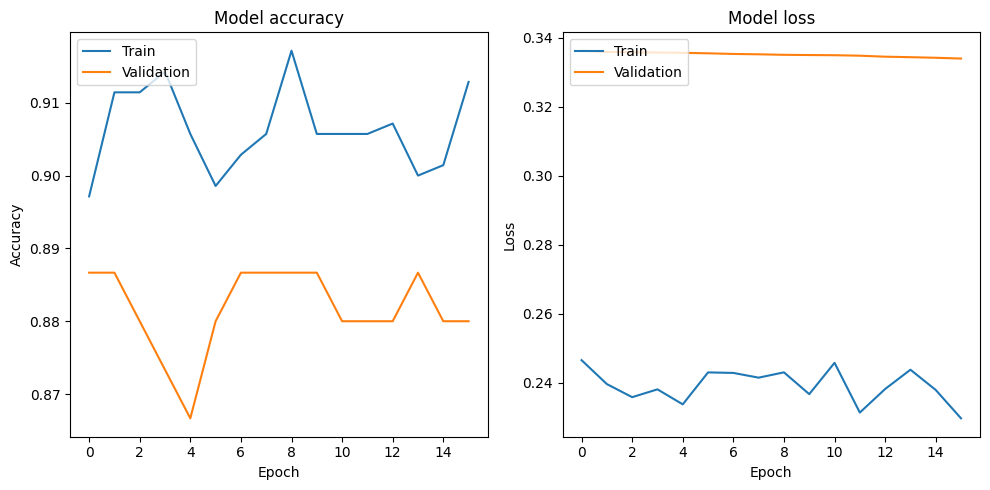

In [ ]:
# prompt: We plot training history accuracy and loss vs epoch

import matplotlib.pyplot as plt

# Assuming history object is available from model training
history = best_model.fit(train_dataset, epochs=200, validation_data=val_dataset, callbacks=callbacks)
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"Test loss: {test_loss} - Test accuracy: {test_acc}")
best_model.save('best_model_with_tuner.keras')

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()



In [ ]:
loaded_model = tf.keras.models.load_model('best_model_with_tuner.keras', custom_objects={'LogTransform': LogTransform, 'Standardize': Standardize, 'DiscreteFeatureEncoder': DiscreteFeatureEncoder})


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


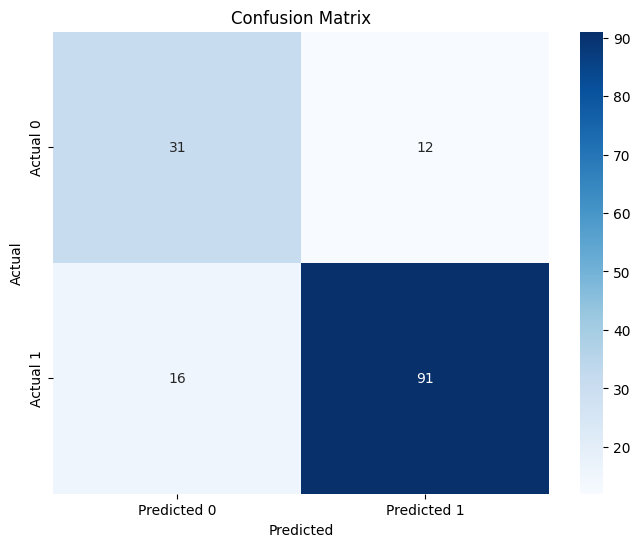

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'y_true' contains the true labels and 'y_pred' contains the predicted probabilities
y_true = []
y_pred_prob = []

for batch in test_dataset:
    X_test, y_batch = batch
    y_pred_batch = loaded_model.predict(X_test)
    y_true.extend(y_batch.numpy())
    y_pred_prob.extend(y_pred_batch)

# Convert probabilities to class labels (0 or 1)
y_pred = (np.array(y_pred_prob) > 0.5).astype(int).flatten()

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
              precision    recall  f1-score   support

           0       0.66      0.72      0.69        43
           1       0.88      0.85      0.87       107

    accuracy                           0.81       150
   macro avg       0.77      0.79      0.78       150
weighted avg       0.82      0.81      0.82       150



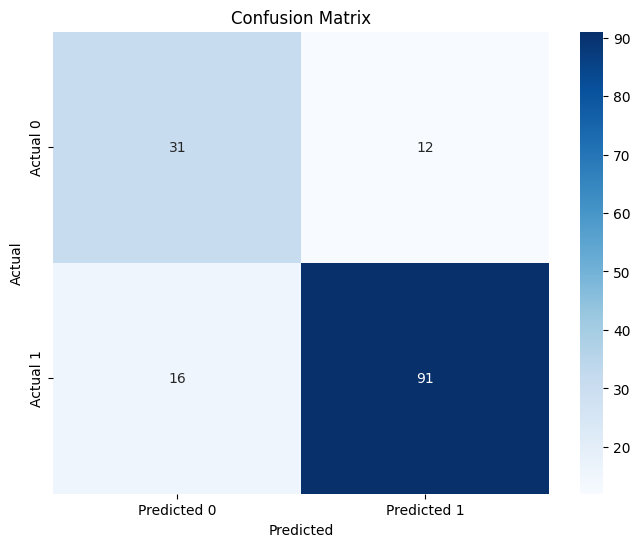

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming 'y_true' contains the true labels and 'y_pred' contains the predicted probabilities
y_true = []
y_pred_prob = []

for batch in test_dataset:
    X_test, y_batch = batch
    y_pred_batch = loaded_model.predict(X_test)
    y_true.extend(y_batch.numpy())
    y_pred_prob.extend(y_pred_batch)

# Convert probabilities to class labels (0 or 1)
y_pred = (np.array(y_pred_prob) > 0.5).astype(int).flatten()

print(classification_report(y_true, y_pred))


# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


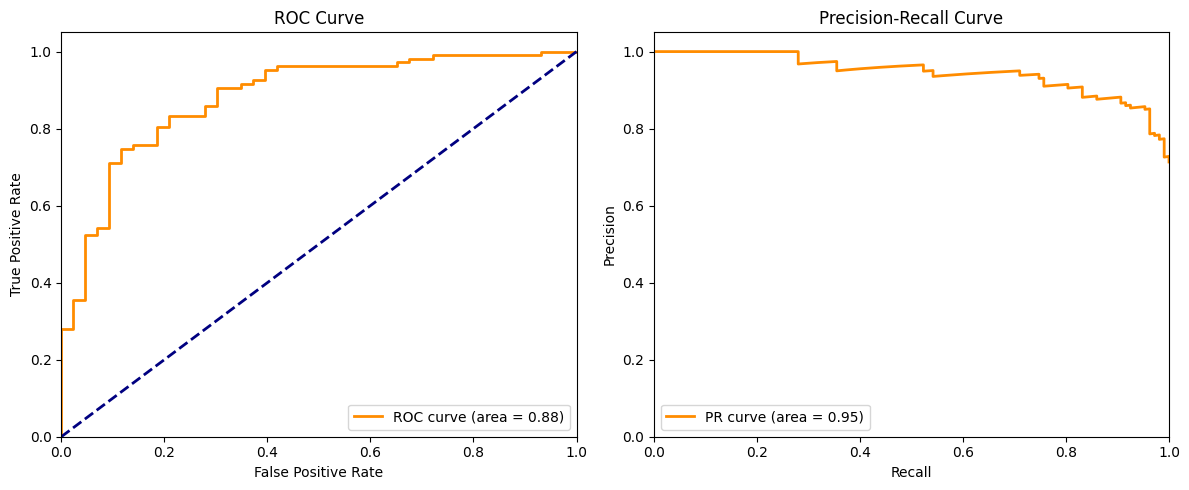

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np

# Assuming y_true and y_pred_prob are defined as in the previous code

# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calculate PR curve
precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred_prob)
pr_auc = average_precision_score(y_true, y_pred_prob)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot ROC curve
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")

# Plot PR curve
axes[1].plot(recall, precision, color='darkorange', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc="lower left")


plt.tight_layout()
plt.show()


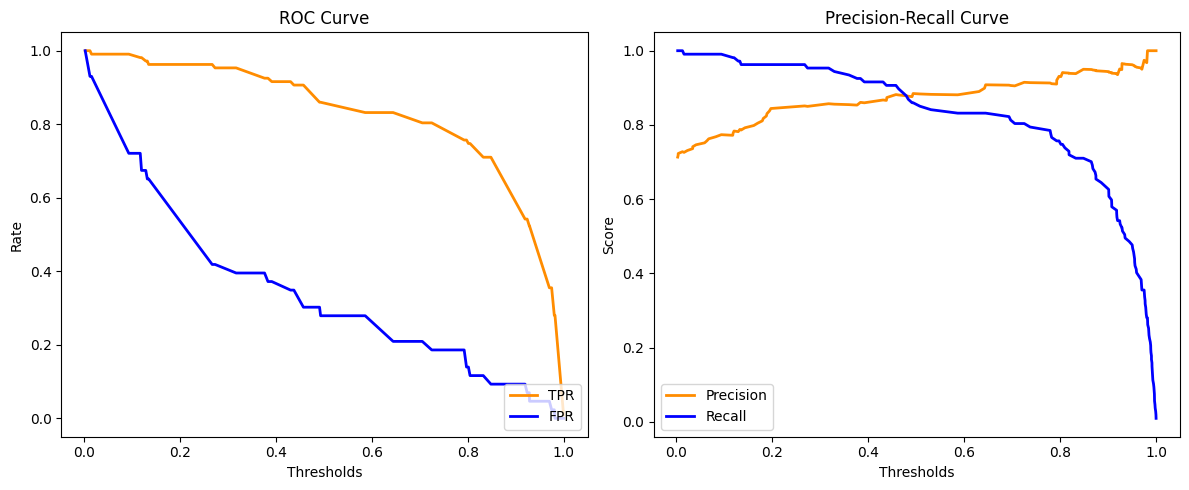

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, roc_curve

# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Calculate PR curve
precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred_prob)
pr_auc = average_precision_score(y_true, y_pred_prob)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot ROC curve
axes[0].plot(thresholds_roc, tpr, color='darkorange', lw=2, label=f'TPR')
axes[0].plot(thresholds_roc, fpr, color='blue', lw=2, label=f'FPR')
axes[0].set_xlabel('Thresholds')
axes[0].set_ylabel('Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")

# Plot PR curve
axes[1].plot(thresholds_pr, precision[:-1], color='darkorange', lw=2, label=f'Precision')
axes[1].plot(thresholds_pr, recall[:-1], color='blue', lw=2, label=f'Recall')
axes[1].set_xlabel('Thresholds')
axes[1].set_ylabel('Score')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc="lower left")

plt.tight_layout()
plt.show()
